<a href="https://colab.research.google.com/github/Bhandari007/player-classfication/blob/main/Player_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Player Classification
>In this notebook, using different python library and packages, I'm going to build a model to predict the player corresponding club using the image of that player. There are 4 clubs in total given in the dataset namely Manchester City, Machester United and Liverpool
Since, the dataset is small and I'm going to use `transfer learning` for building the model.

# Problem Statement
>Given an image of the player, the model has to predict the name of the club that the player plays for

The steps followed are:-
1. Data Collection
2. Getting to know the data
3. Model Building
4. Model Evaluation

# 1. Data Collection

The images were downloaded from the google. One can download the dataset from the following link:<br>
 <a herf = "https://github.com/Bhandari007/player-classfication/blob/main/image_dataset.zip?raw=true">Dataset</a>

### Downloading dataset

In [ ]:
#!wget https://github.com/Bhandari007/player-classfication/blob/main/image_dataset.zip?raw=true

### Unzipping the Folder

In [1]:
import zipfile
zip_ref = zipfile.ZipFile("image_dataset.zip")
zip_ref.extractall()
zip_ref.close()

# Getting to know the data

### No of images in each folder

In [2]:
import os
for dirpath, dirnames, filenames in os.walk("image_dataset"):
  print(f"There are {len(filenames)} images in {dirpath} ")

There are 0 images in image_dataset 
There are 0 images in image_dataset/train 
There are 37 images in image_dataset/train/manchester_city 
There are 38 images in image_dataset/train/liverpool 
There are 46 images in image_dataset/train/manchester_united 
There are 0 images in image_dataset/test 
There are 15 images in image_dataset/test/machester_united 
There are 14 images in image_dataset/test/machester_city 
There are 16 images in image_dataset/test/liverpool 


### Create training and test directory paths


In [3]:
train_dir = "image_dataset/train"
test_dir = "image_dataset/test"

In [4]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 8


train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode = "categorical"
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    label_mode = "categorical"
)
NUM_CLASS = len(train_data.class_names)

Found 120 files belonging to 3 classes.
Found 43 files belonging to 3 classes.


### Viewing the class names

In [30]:
class_names = train_data.class_names

In [5]:
print(f"The classes are: {train_data.class_names}")

The classes are: ['liverpool', 'manchester_city', 'manchester_united']


### Plotting a random image

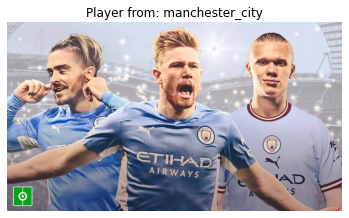

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

target_class = random.choice(train_data.class_names)
target_dir = "image_dataset/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Player from: {target_class}")
plt.axis(False);

# Model Building

In this section, I will try out different expirement so as to find out the model that fits the dataset. 

The series of expirements can be summarized as:-

* `model_0`: model building with [MobileNetV1](https://tfhub.dev/google/imagenet/mobilenet_v1_050_192/feature_vector/5) architecture
* `model_1`: model building with [EfficientNetB0](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) architecture



### Setting up functions for conducting experimenets

#### URL of models

In [27]:
net_v1_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_192/feature_vector/5"
efficient_net_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

#### Setting up callback


In [8]:
import datetime

def create_tensorboard_callbacks(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving log files to: {log_dir}")
  return tensorboard_callback

In [9]:
import tensorflow_hub as hub

#### Function for building model

In [10]:

def build_model(model_url):
  """
  Returns a keras model

  Arguments:
    model_url -- the url of the model to be built from the tensorflowhub website
    data_augmentation -- bool value
                        True (for adding data agumentation layer)
                        False(default [no data augmentation layer])
  Returns:
    model -- a keras sequential model
  """
  # Download the pretrained model and save it a keras layer
  tf.random.set_seed(42)
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name = "feature_extraction_layer",
                                           input_shape = IMG_SIZE+(3,),
                                           )
  
  # Create model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(3, activation="softmax", name = "output_layer")
  ])

  return model

In [ ]:
IMG_SIZE + (3,)

(224, 224, 3)

#### Plotting the loss curves

In [11]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Model 0

### Creating MobileNetV1 model

In [12]:
model_0 = build_model(net_v1_url)
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 512)              829536    
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 1539      
                                                                 
Total params: 831,075
Trainable params: 1,539
Non-trainable params: 829,536
_________________________________________________________________


### Compiling the net_v1_model

In [13]:
model_0.compile(loss="categorical_crossentropy",
                                      optimizer = tf.keras.optimizers.Adam(),
                                      metrics = ["accuracy"])

### Fit the model 0

In [14]:
tf.random.set_seed(42)
model_0_history = model_0.fit(train_data,
            epochs = 5,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data),
            callbacks = [create_tensorboard_callbacks(dir_name="tensorflow_hub",experiment_name="mobile_net_e1")])

Saving log files to: tensorflow_hub/mobile_net_e1/20221016-020744
Epoch 1/5
15/15 [==============================] - 10s 82ms/step - loss: 1.4174 - accuracy: 0.3250 - val_loss: 1.1765 - val_accuracy: 0.3721
Epoch 2/5
15/15 [==============================] - 1s 51ms/step - loss: 1.0206 - accuracy: 0.4750 - val_loss: 1.0291 - val_accuracy: 0.4651
Epoch 3/5
15/15 [==============================] - 1s 50ms/step - loss: 0.9685 - accuracy: 0.5583 - val_loss: 1.0098 - val_accuracy: 0.4651
Epoch 4/5
15/15 [==============================] - 1s 50ms/step - loss: 0.8865 - accuracy: 0.6417 - val_loss: 0.9985 - val_accuracy: 0.4419
Epoch 5/5
15/15 [==============================] - 1s 51ms/step - loss: 0.8336 - accuracy: 0.7000 - val_loss: 0.9859 - val_accuracy: 0.4884


### Plotting the loss curves

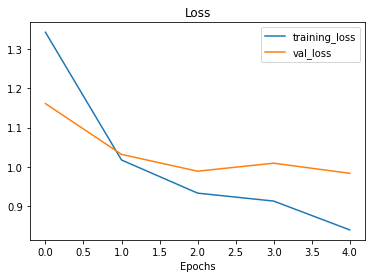

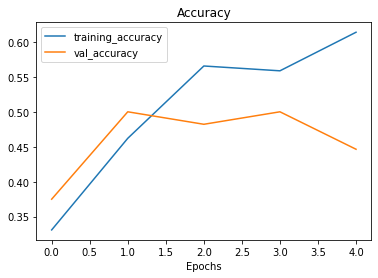

In [ ]:
plot_loss_curves(model_0_history)

### Conclusion
* Baseline accuracy ~ 100 %
* Training accuracy ~ 70%
* Validation accuracy ~ 40 %

We can conclude that the model 0 has high bias and high variance.

To reduce high bias we can increase `training time (epochs)` or `choose a new architecture.`

## Option 0: Increase number of epochs

In [15]:
model_0 = build_model(net_v1_url)
model_0.summary()
model_0.compile(loss="categorical_crossentropy",
                                      optimizer = tf.keras.optimizers.Adam(),
                                      metrics = ["accuracy"])
tf.random.set_seed(42)
model_0_history = model_0.fit(train_data,
            epochs = 20,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data),
            callbacks = [create_tensorboard_callbacks(dir_name="tensorflow_hub",experiment_name="mobile_net_e2")])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 512)              829536    
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 1539      
                                                                 
Total params: 831,075
Trainable params: 1,539
Non-trainable params: 829,536
_________________________________________________________________
Saving log files to: tensorflow_hub/mobile_net_e2/20221016-020908
Epoch 1/20
15/15 [==============================] - 3s 68ms/step - loss: 1.2897 - accuracy: 0.3917 - val_loss: 1.1712 - val_accuracy: 0.3953
Epoch 2/20
15/15 [==============================] - 1s 50ms/step - loss: 1.0396 - accuracy: 0.5167 - val_loss: 1.0294 - val_accuracy: 0.5349
Epoch 3/20
15/15 [========

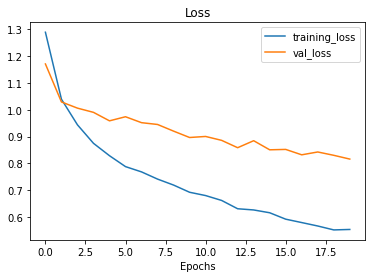

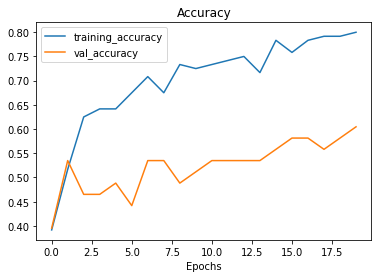

In [16]:
plot_loss_curves(model_0_history)

### Conclusion
* Baseline accuracy ~ 100 %
* Training accuracy ~ 80%
* Validation accuracy ~ 60 %

Increasing number of epochs didnot work.


## Option 1: Select different Architecture

In [17]:
model_1 = build_model(efficient_net_url)
model_1.summary()
model_1.compile(loss="categorical_crossentropy",
                                      optimizer = tf.keras.optimizers.Adam(),
                                      metrics = ["accuracy"])
tf.random.set_seed(42)
model_1_history = model_1.fit(train_data,
            epochs = 20,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = len(test_data)
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 10s 143ms/step - loss: 300.0280 - accuracy: 0.3250 - val_loss: 380.7531 - val_accuracy: 0.4651
Epoch 2/20
15/15 [==============================] - 1s 58ms/step - loss: 142.4110 - accuracy: 0.4333 - val_loss: 406.2598 - val_accuracy: 0.4419
Epoch 3/20
15/15 [==============================] - 1s 65ms/step - loss: 73.85

### Conclusion

The model we fit has high variance.(overfitting problem)

To reduce, we can increase the number of training set by data augmentation.

# Option 2: Data Augmentation

In [18]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(height_factor=0.8,width_factor=1),
    tf.keras.layers.RandomContrast(0.2,0.5),
    tf.keras.layers.RandomRotation(0.2)
])

## Model 2: EfficientNet

### Build Model

In [20]:
model_2 = build_model(efficient_net_url)

### Data Augmentation

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)
test_ds = test_data.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

In [22]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 3,843
Non-trainable params: 4,049,564
_________________________________________________________________


### Compiling the model

In [23]:
model_2.compile(loss="categorical_crossentropy",
                metrics = ["accuracy"],
                optimizer = tf.keras.optimizers.Adam())

### Training the model

In [24]:
model_2_history = model_2.fit(train_ds,
                              epochs = 20,
            steps_per_epoch = len(train_ds),
            validation_data = test_ds,
            validation_steps = len(test_ds),
            callbacks = create_tensorboard_callbacks("tensorflow_hub","efficient_net_data_augmented"))

Saving log files to: tensorflow_hub/efficient_net_data_augmented/20221016-021428
Epoch 1/20
15/15 [==============================] - 13s 297ms/step - loss: 1.0875 - accuracy: 0.4250 - val_loss: 0.8364 - val_accuracy: 0.7209
Epoch 2/20
15/15 [==============================] - 4s 217ms/step - loss: 0.8587 - accuracy: 0.5917 - val_loss: 0.7649 - val_accuracy: 0.6744
Epoch 3/20
15/15 [==============================] - 4s 216ms/step - loss: 0.7275 - accuracy: 0.6833 - val_loss: 0.6507 - val_accuracy: 0.8140
Epoch 4/20
15/15 [==============================] - 3s 174ms/step - loss: 0.6338 - accuracy: 0.7417 - val_loss: 0.6840 - val_accuracy: 0.7209
Epoch 5/20
15/15 [==============================] - 4s 218ms/step - loss: 0.5860 - accuracy: 0.7583 - val_loss: 0.5741 - val_accuracy: 0.7674
Epoch 6/20
15/15 [==============================] - 3s 174ms/step - loss: 0.5249 - accuracy: 0.7917 - val_loss: 0.6324 - val_accuracy: 0.6512
Epoch 7/20
15/15 [==============================] - 3s 182ms/step 

### Plotting the loss curves

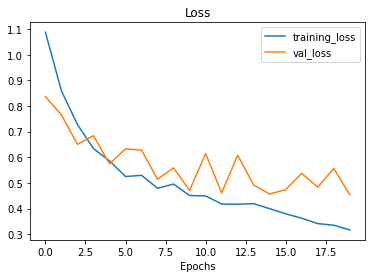

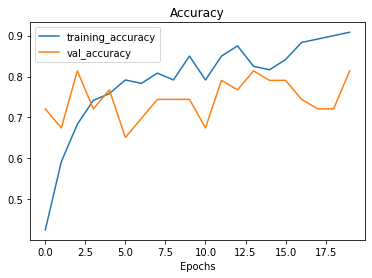

In [26]:
plot_loss_curves(model_2_history)

### Conclusion

* Training Accuracy: 90 %
* Validation Accuracy: 81 %

Although model has fitted well to the training data, it still has some variance. Given that we have less amount of data we can be satsified with the performance of this model

# Model Evaluation

### Function to load and prepare images

In [29]:
def load_and_prep_image(filename, img_shape = 224, scale = True):

  # Read the image
  img = tf.io.read_file(filename)

  # Decode the image to tensor
  img = tf.io.decode_image(img, channels = 3)

  # Resize the image
  img = tf.image.resize(img, [img_shape,img_shape])

  # Scale? Yes / No
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  
  else:
    return img

### Model Predictions

1/1 [==============================] - 0s 25ms/step
liverpool
[[9.9999809e-01 5.2352396e-15 1.8875928e-06]]


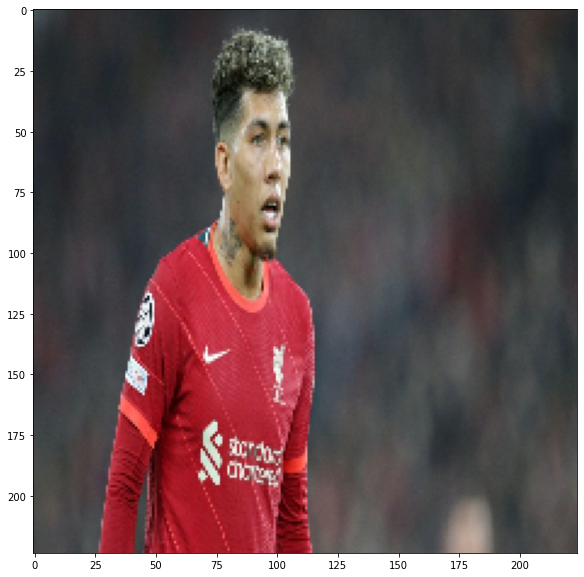

In [69]:
plt.figure(figsize=(17,10))
filename = os.listdir(test_dir + "/" + "liverpool")
filepath = test_dir + "/liverpool" + "/" + filename[1]
# Load the image and make predictions
img = load_and_prep_image(filepath, scale = False)
img_expanded = tf.expand_dims(img, axis=0)
pred_prob = model_2.predict(img_expanded)
pred_class = class_names[pred_prob.argmax()]
print(pred_class)
print(pred_prob)
plt.imshow(img/255.)

1/1 [==============================] - 0s 38ms/step
manchester_united
[[0.0000000e+00 3.0894927e-05 9.9996912e-01]]


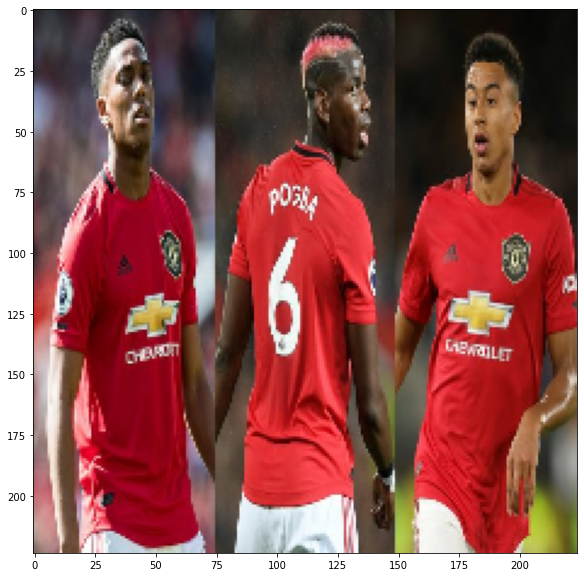

In [74]:
plt.figure(figsize=(17,10))
filename = os.listdir(test_dir + "/" + "machester_united")
filepath = test_dir + "/machester_united" + "/" + filename[1]
# Load the image and make predictions
img = load_and_prep_image(filepath, scale = False)
img_expanded = tf.expand_dims(img, axis=0)
pred_prob = model_2.predict(img_expanded)
pred_class = class_names[pred_prob.argmax()]
print(pred_class)
print(pred_prob)
plt.imshow(img/255.)

1/1 [==============================] - 0s 42ms/step
manchester_united
[[0. 0. 1.]]


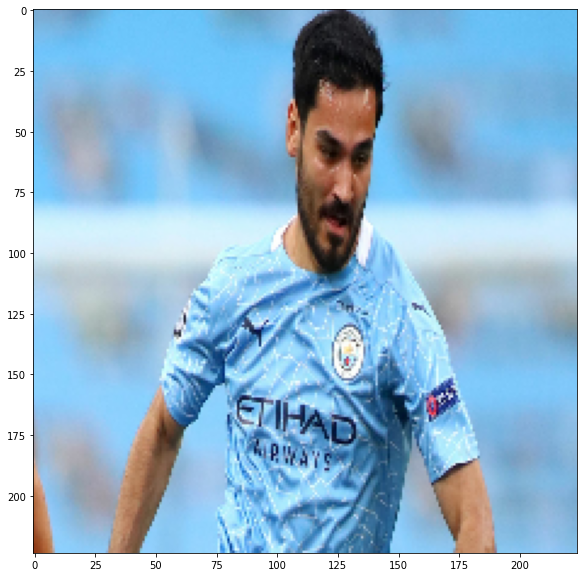

In [77]:
plt.figure(figsize=(17,10))
filename = os.listdir(test_dir + "/" + "machester_city")
filepath = test_dir + "/machester_city" + "/" + filename[1]
# Load the image and make predictions
img = load_and_prep_image(filepath, scale = False)
img_expanded = tf.expand_dims(img, axis=0)
pred_prob = model_2.predict(img_expanded)
pred_class = class_names[pred_prob.argmax()]
print(pred_class)
print(pred_prob)
plt.imshow(img/255.)